In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re 
import difflib 



In [2]:
def cleaning(MVA_DF):
    print("original size : ", len(MVA_DF))
    MVA_DF= MVA_DF.reset_index(drop=True)
    reg = re.compile("((.*)?I(-|\s)?(-|\s)?\d+)(.*)?|(.*)?((S|R)(.)?(R|T)(.)?(\s)?\d+)(.*)?")
    count = 0
    pattern_digitAV = re.compile("^(^[0-9])([A-Z].*)") #If start with one digit and followed by str
    dico = {"HWY" : "HY", "RT " : "I-","INTERSTATE ": "I-","STATE ROUTE ": "I-","STREET": "ST","AVENUE":"AV","AVE":"AV"} 
    for i in range(len(MVA_DF)) : #When finished, len(DF)
        #print("ONE  : ",(MVA_DF["PRIMARY_RD"])[i]," Intersection : ",(MVA_DF["SECONDARY_RD"])[i])
        (MVA_DF["PRIMARY_RD"])[i] = multiple_replace(dico,(MVA_DF["PRIMARY_RD"])[i]) #Get the street name
        (MVA_DF["SECONDARY_RD"])[i] = multiple_replace(dico,(MVA_DF["SECONDARY_RD"])[i]) #Get intersection 
        digit_AV_street = pattern_digitAV.match((MVA_DF["PRIMARY_RD"])[i]) # Check if match with pattern
        digit_AV_Inter =pattern_digitAV.match((MVA_DF["SECONDARY_RD"])[i]) # Check if match with pattern
        if digit_AV_Inter is not None : 
            (MVA_DF["SECONDARY_RD"])[i]= "0" + digit_AV_Inter.group()    #Add a 0 in front if match
        if digit_AV_street is not (None):
            (MVA_DF["PRIMARY_RD"])[i] = "0" + digit_AV_street.group() #Add a 0 in front if match
        if reg.match((MVA_DF["PRIMARY_RD"])[i]):
            #print((MVA_DF["PRIMARY_RD"])[i])
            MVA_DF.drop(i, inplace=True)
            count = count+1
    MVA_DF = MVA_DF.loc[MVA_DF.PCF_VIOL_CATEGORY != '1'] #If driving under drugs or alcohol
    print("count",count)
    print("lenDF: ",len(MVA_DF))
    return (MVA_DF)

In [30]:
#Function to aply multiple conditions/regexp on string
def multiple_replace(dico, name_street):
    regex = re.compile("(%s)" % "|".join(map(re.escape, dico.keys()))) #Create reg exp from dico
    return (regex.sub(lambda mo: dico[mo.string[mo.start():mo.end()]], name_street) ) #If there is a match, replace it with the corresponding value in dico




In [ ]:
col_name = ["COLLISION_DATE","COLLISION_TIME","PRIMARY_RD","SECONDARY_RD","CHP_BEAT_TYPE","WEATHER_1","COLLISION_SEVERITY","PRIMARY_COLL_FACTOR","PCF_VIOL_CATEGORY","LIGHTING","ROAD_SURFACE","ROAD_COND_1"]
MVA_DF = pd.DataFrame(data=None, index=None, columns=col_name, dtype=None) #New empty dataframe
size=0
for i in range (4):
    year = 2010 + (i+1) #File name
    if year != 2012 : 
        DF = pd.read_csv('CollisionRecords%i.txt' % year,sep = ',', dtype='unicode') #Read the csv file
        DF = DF[col_name]
        DF = cleaning(DF)
        #print(len(DF))
        size += len(DF) #Check size matches 
        MVA_DF = MVA_DF.append(DF)#Add DF to our initialized dataframe

     
#Just to check
print(size)#Just to check


original size :  7840
count 3808
lenDF:  4032
original size :  8858
count 4920
lenDF:  3938
original size :  9503


In [6]:
year = 2011 #Only OCI file that I have 
DF_OCI = pd.read_csv('OCI_SD_%i.csv' % year,sep = ',', dtype='unicode') #Read the csv file
DF_OCI= DF_OCI[['oci','street','street_from','street_to','oci_desc']] #Keep only relevant variables

In [29]:
def inter(TEMP,intersection_len,intersection,i) : 
    TEMP2 = pd.DataFrame(data=None, index=None, columns= None, dtype=None) #New empty dataframe    
    TEMP2 = TEMP.loc[(TEMP['street_from'] == intersection)|(TEMP['street_to']==(intersection))]   #If perfect match in either street to or street from (OCI DF)
    if TEMP2.empty : #If nothing matched
        Close_Match_Intersection = (difflib.get_close_matches(intersection, (TEMP['street_from']),n=1)) #Same idea but with close_match and chose the closest (n=1)
        Close_Match_To = (difflib.get_close_matches(intersection, (TEMP['street_to']),n=1)) #Same for street to
        if (Close_Match_Intersection != []) & (Close_Match_To != []) : #If both have matched
            TEMP2 = TEMP.loc[(TEMP['street_from'] == Close_Match_Intersection[0])|(TEMP['street_to']== Close_Match_To[0])]
        elif (Close_Match_Intersection != []) : #Only street from
            TEMP2 = TEMP.loc[(TEMP['street_from'] == Close_Match_Intersection[0])]
        elif (Close_Match_To != []) : #Only street to
            TEMP2 = TEMP.loc[(TEMP['street_to'] == Close_Match_To[0])]
        else : #Nothing matched
            print("Street : ",street_name," Intersection : ",intersection,"INDEX : ",i)
            intersection_len = intersection_len +1 #No intersection matched - 
            TEMP2 = TEMP #Stay with all the street names even if intersection don't match - Will be sorted out by the Dataframe function (Just in case one street has same OCI everywhere)
    if TEMP2 is not None : 
        return(TEMP2,intersection_len)

        

In [8]:
def dataframe(TEMP,i,DF):
    TEST = pd.DataFrame(data=None, index=None, columns= None, dtype=None) #New temporary DF
    TEMP = TEMP.reset_index(drop=True)#From OCI DF
    TEMP1 = MVA_DF.loc[MVA_DF.index == i] #Get the corresponding row
    TEMP1 = TEMP1.reset_index(drop=True) #So there is no index problem when join
    a = True 
    length = len(TEMP) #To see if 0 or 1 or more rows matched in OCI
    if length ==1 : #If one then perfect
        TEST = TEMP.join(TEMP1) #Join OCI row to MVA row (and keep all the colulns from both DF)
        DF = DF.append(TEST) #Add it to the merged DF
    elif length > 1 : #If more than one matched
        for j in range(len(TEMP)-1) :
            if (TEMP['oci_desc'])[j] != (TEMP['oci_desc'])[j+1]: #If not all OCI_desc are the same, we took the decision not to include in DF
                a = False #Set in to False so it wont add it
        if a == True : 
            TEMP = TEMP.loc[[0]] #Chose the first row out of all the possibilities (but all have same OCI desc)
            TEST = TEMP.join(TEMP1)#Join
            DF = DF.append(TEST)#Add it to DF
    if DF is not None :
        return(DF)

In [10]:
DF = pd.DataFrame(data=None, index=None, columns= None, dtype=None) #Will be final merged DF
street_len = 0 #Var for number of Primary_RD not matching street name
intersection_len = 0 #Var for number of Secondary_RD not matching street_from or street_to
MVA_DF= MVA_DF.reset_index(drop=True)

for i in range(len(MVA_DF)) : #Loop through all the DF with the Accidents/Collisison
    street_name = (MVA_DF["PRIMARY_RD"])[i] #Get street_name from Primary_RD
    intersection = (MVA_DF["SECONDARY_RD"])[i] #Get the Secondary_RD/Intersection 
    TEMP = DF_OCI.loc[(DF_OCI['street'].str.contains(street_name))] #Get all the street in the OCI that contains or is equal to street_name (from MVA_DF)    
    if TEMP.empty: #If nothing matchs
        Close_Match_Street = (difflib.get_close_matches(street_name, (DF_OCI['street']),n=1)) #Function that finds the closest match - Chose to only take one out of the different matches
        if (Close_Match_Street != []) : #If there is a match
            TEMPA = DF_OCI.loc[DF_OCI['street'].str.contains(Close_Match_Street[0])] #Get all the street names from DF_OCI that contain or is equal to this new close match
            TEMP3,intersection_len= inter(TEMPA,intersection_len,intersection,i)
            if not TEMP3.empty : 
                DF = dataframe(TEMP3,i,DF)
        else :
            street_len = street_len +1
            print("No street match")
            print("Street : ",street_name," Intersection : ",intersection)        
    else : 
        TEMP2,intersection_len= inter(TEMP,intersection_len,intersection,i) #Get all the possibilities of inter match from the street match (TEMP)
        DF= dataframe(TEMP2,i,DF) #Merge the MVA row and OCI DF that matched 

    print(i) #Just to know how long you still have to wait until it's done

0
1
Street :  54TH ST  Intersection :  54TH ST 3000 INDEX :  2
2
3
4
Street :  CAMINO SANTA FE  Intersection :  MIRAMAR RD INDEX :  5
5
6
Street :  CAMINO DEL RIO W  Intersection :  KURTZ ST INDEX :  7
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Street :  FRIARS RD  Intersection :  I-15 INDEX :  27
27
28
Street :  PALM AV  Intersection :  PICCARD AV INDEX :  29
29
Street :  SKYLINE DR  Intersection :  GRIBBLE ST INDEX :  30
30
Street :  PACIFIC HY  Intersection :  TAYLOR ST INDEX :  31
31
32
33
34
Street :  WOODMAN  Intersection :  WOODMAN 200 INDEX :  35
35
36
37
38
39
Street :  ROSECRANS ST  Intersection :  SPORTS ARENA BL INDEX :  40
40
41
42
43
44
45
46
Street :  AVNIDA SUAVIDAD  Intersection :  AVNIDA SUAVIDAD 16265 INDEX :  47
47
48
49
50
51
52
Street :  PERSHING DR  Intersection :  B ST INDEX :  53
53
Street :  BLACK MOUNTAIN RD  Intersection :  BLACK MOUNTAIN RD 10600 INDEX :  54
54
Street :  CAMINO DEL NORTE  Intersection :  I-15 INDEX :  55
55
56
Street :  16TH S

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.


Street :  PALM SB AV  Intersection :  18TH ST INDEX :  1511
1511
1512
1513
1514
1515
Street :  POTOMAC ST  Intersection :  RACHEL AV INDEX :  1516
1516
1517
1518
1519
1520
Street :  REED ST  Intersection :  FANUEL AV INDEX :  1521
1521
1522
1523
Street :  CAMINO DEL RIO  Intersection :  HANCOCK ST INDEX :  1524
1524
1525
1526
1527
1528
1529
1530
1531
Street :  POPLAR ST  Intersection :  JAIME DR INDEX :  1532
1532
Street :  BANCROFT ST  Intersection :  BANCROFT ST4600 INDEX :  1533
1533
1534
1535
1536
1537
Street :  CARMEL COUNTRY RD  Intersection :  GRAND DEL MAR INDEX :  1538
1538
1539
Street :  CARMEL VALLEY RD  Intersection :  I-56 INDEX :  1540
1540
1541
1542
1543
1544
1545
1546
1547
1548
1549
1550
Street :  OCEAN FRONT WALK  Intersection :  VENTURA PL INDEX :  1551
1551
1552
1553
1554
1555
1556
1557
1558
Street :  MIDWAY DR  Intersection :  WEST POINT LOMA BL INDEX :  1559
1559
1560
1561
1562
Street :  SULPIN ST  Intersection :  MC CLOY WY INDEX :  1563
1563
1564
1565
1566
1567
S

1255 1677 4119


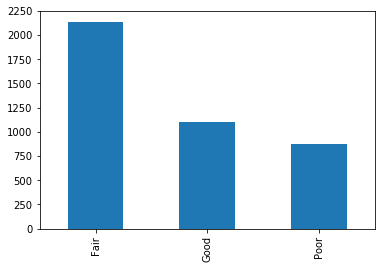

,oci,street,street_from,street_to,oci_desc,COLLISION_DATE,COLLISION_TIME,PRIMARY_RD,SECONDARY_RD,CHP_BEAT_TYPE,WEATHER_1,COLLISION_SEVERITY,PRIMARY_COLL_FACTOR,PCF_VIOL_CATEGORY,LIGHTING,ROAD_SURFACE,ROAD_COND_1
0,39.67,EL PASEO GRANDE,CALLE CLARA,VALLECITOS,Poor,20111003,1810,EL PASEO GRANDE,CALLE CLARA,0,B,3,A,13,A,A,H
1,86.43,MONTEZUMA RD,COLLWOOD BL,YERBA SANTA DR,Good,20110427,1420,MONTEZUMA RD,YERBA SANTA RD,0,A,3,A,08,A,A,H
2,51.44,MIRAMAR RD,BLACK MTN RD,KEARNY VILLA RD,Fair,20110518,1030,MIRA MAR RD,KEARNY VILLA RD,0,A,4,A,12,A,A,H
3,65.88,EL CAJON BL,46TH ST,46TH ST,Fair,20110530,1738,EL CAJON BL,36TH ST,0,A,2,A,03,A,A,H
4,51.34,MONROE AV,MISSION AV,ALABAMA ST,Fair,20110529,2237,MONROE AV,ALABAMA ST,0,A,3,A,08,C,A,H
5,78.45,EUCLID AV,ELM ST,WESTOVER PL,Good,20110103,1730,EUCLID AV,WESTOVER ST,0,B,4,A,03,C,A,H
6,78.8,MISSION BL,SAN RAFAEL PL,VENICE CT,Good,20110103,1010,MISSION BL,SAN RAFAEL,0,B,4,A,03,A,A,H
7,51,SAN DIEGO MISSION RD,MISSION VILLAGE DR,RANCHO MISSION RD,Fair,20110101,1856,SAN DIEGO MISSION RD,RANCHO MISSION,0,A,4,A,03,B,A,H
8,54.34,MIRAMAR RD,CABOT DR,CAM RUIZ,Fair,20110104,2356,MIRAMAR RD,CAMINO RUIZ,0,A,3,A,09,C,A,H
9,43.86,FAIRMOUNT AV OFF RA,FAIRMOUNT AV,END,Fair,20110104,1441,FAIRMOUNT AV,FAIRMOUNT AV 4400,0,A,4,A,08,A,A,H


In [11]:
DF= DF.reset_index(drop=True)
print(street_len,intersection_len,len(DF))
plt.figure()
DF.oci_desc.value_counts().plot(kind='bar') #far from good model but just to have an idea
plt.show()
DF.to_csv('Final_DF.csv')
DF

In [25]:
import statsmodels.api as sm
from scipy.stats import chi2_contingency

In [28]:
x = pd.value_counts(DF_OCI['oci_desc'].values,sort=False)
y = DF_OCI.count()
liste = []
x1 = pd.value_counts(DF['oci_desc'].values,sort=False)
y1 = DF.count()
liste1 = []
for i in range (len(x)): 
    liste.append(x[i]/y[1])
    liste1.append(x1[i]/y1[1])

obs = np.array([liste, liste1])
chi2, p, dof, expected = scipy.stats.chi2_contingency(obs)
print (p)

4.65270948106e-160


In [16]:
x1 = pd.value_counts(DF['oci_desc'].values,sort=False)
y1 = DF.count()

x1

Good    1105
Fair    2138
Poor     876
dtype: int64